(-0.5, 319.5, 319.5, -0.5)

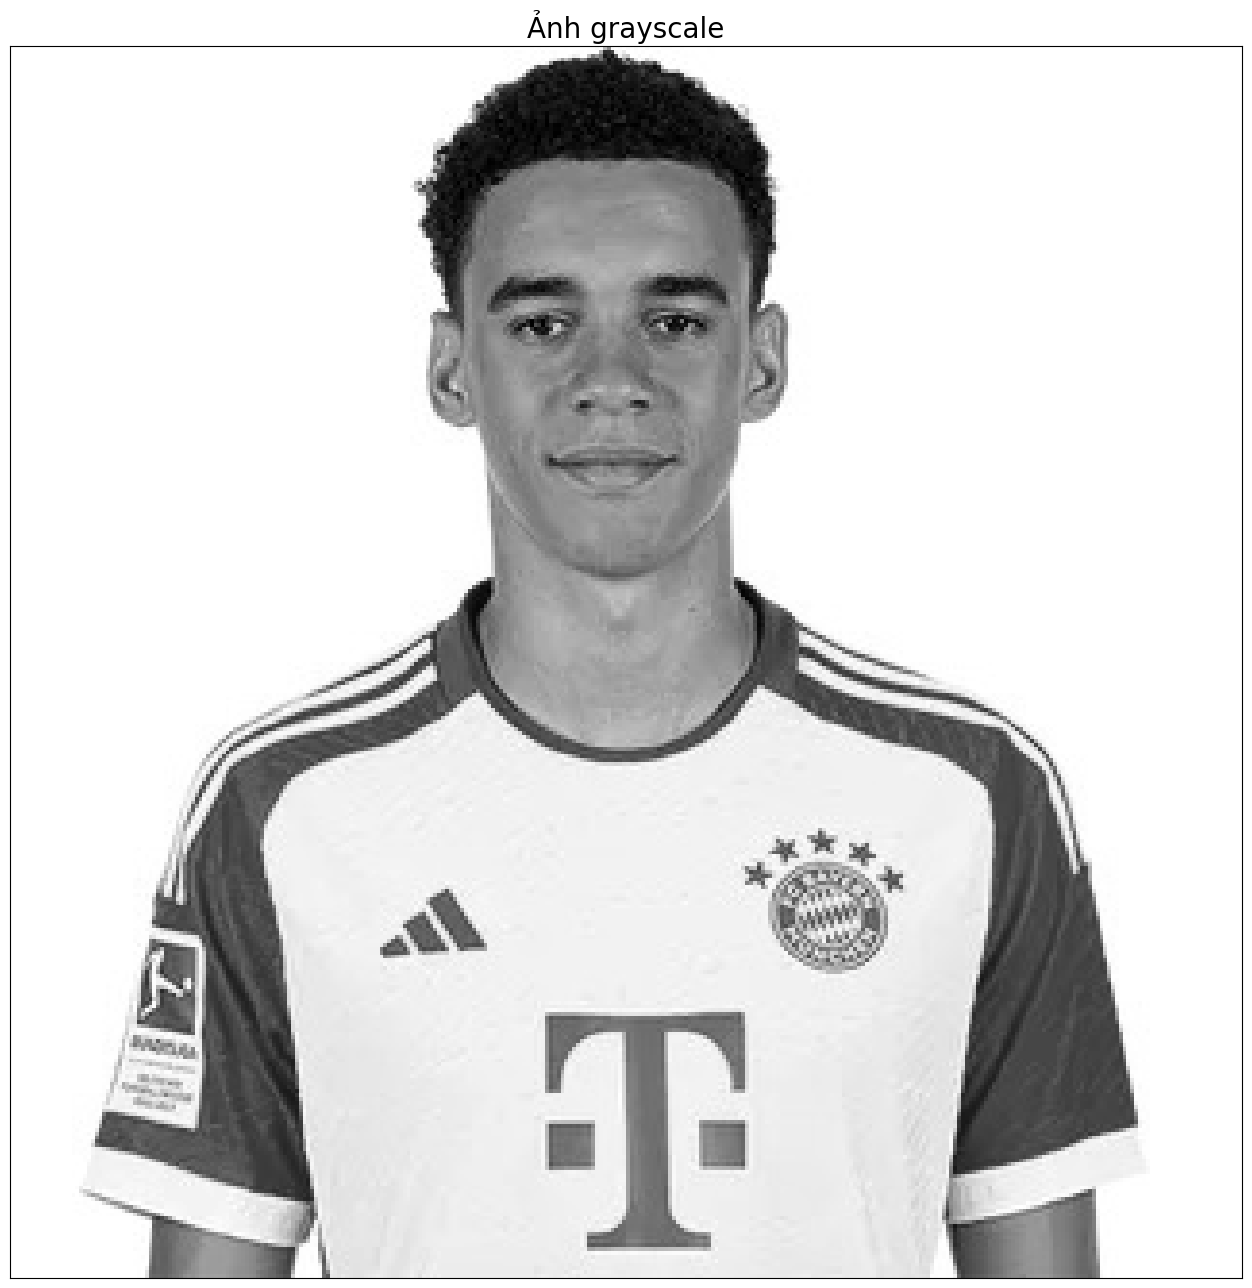

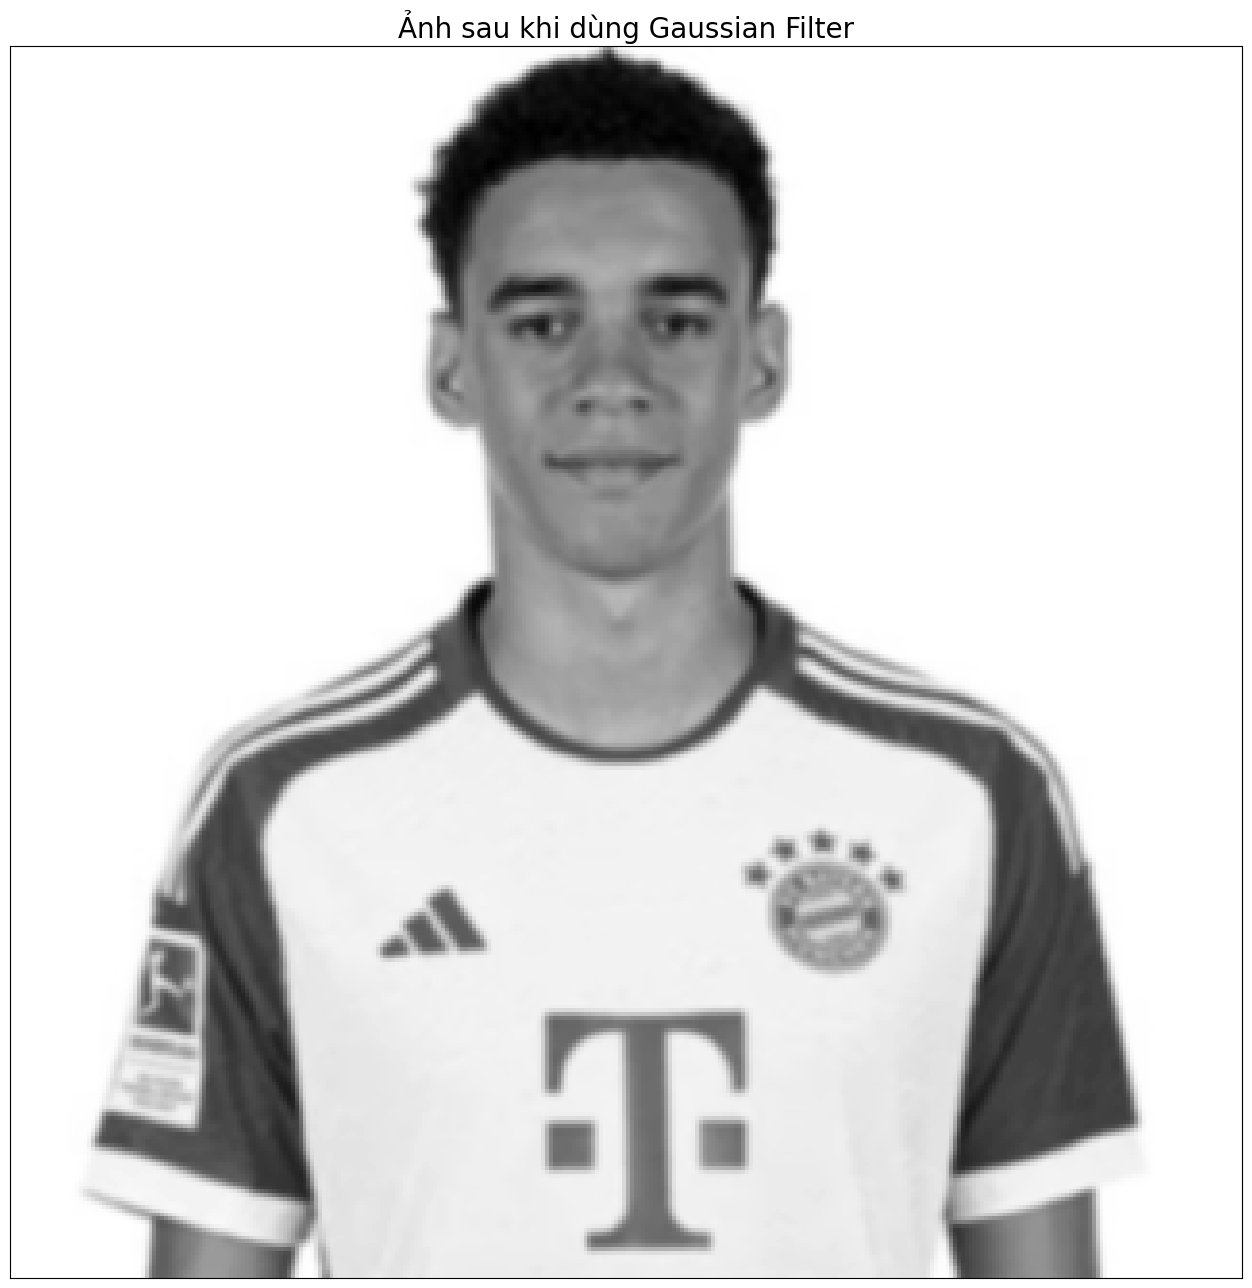

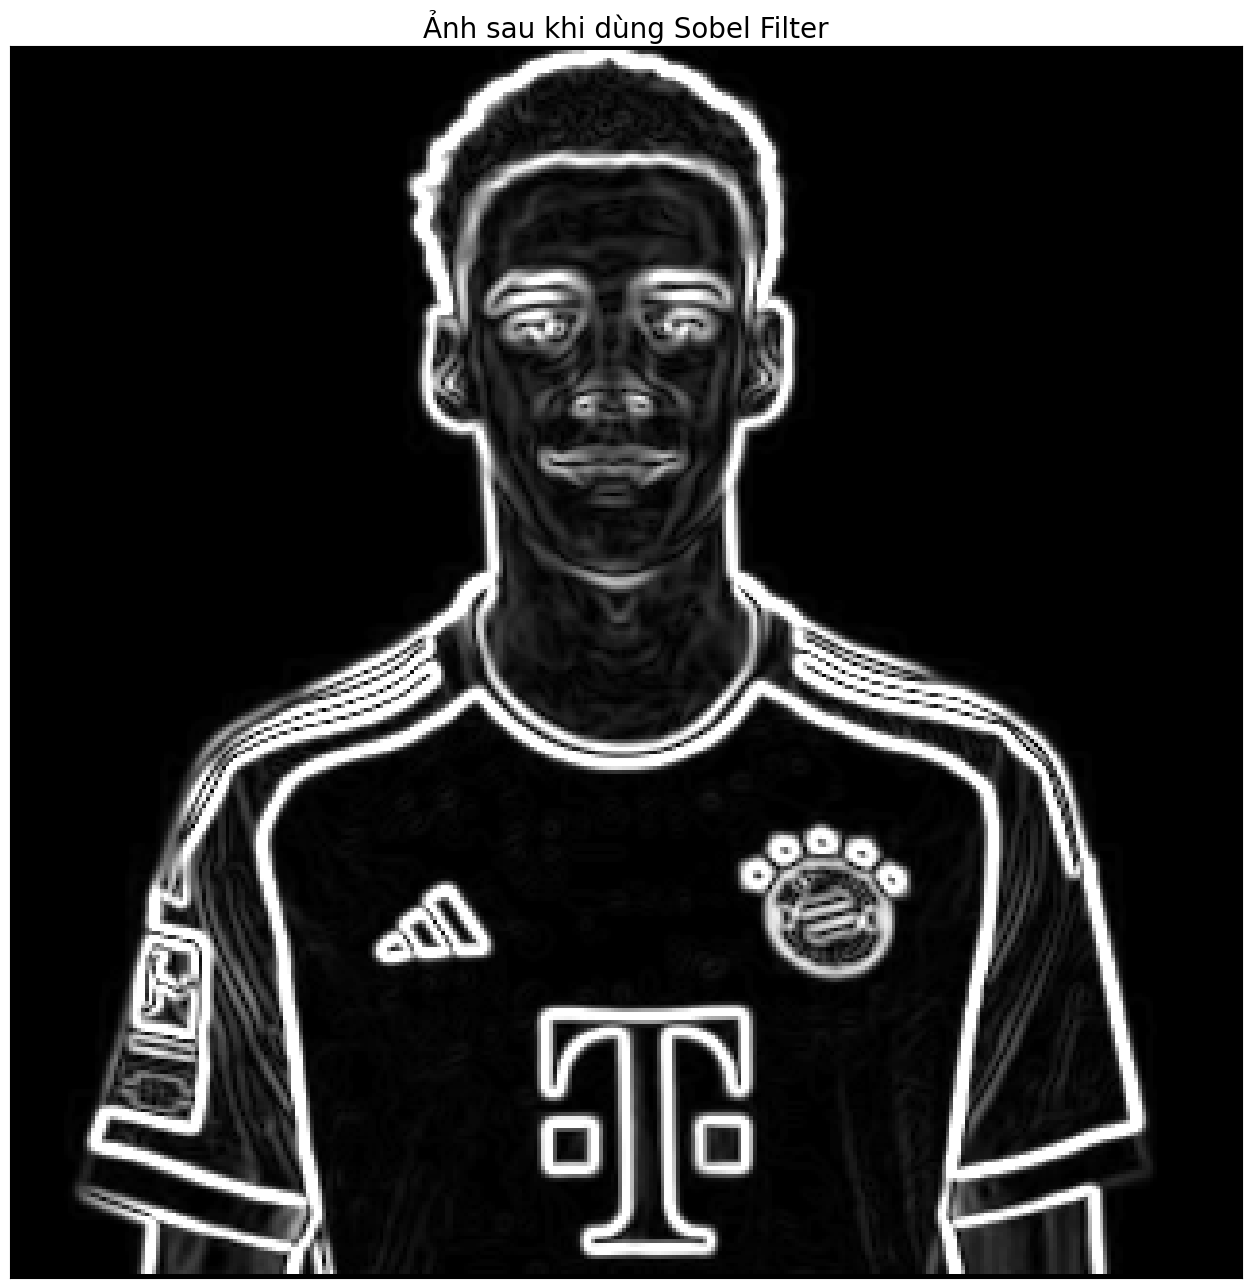

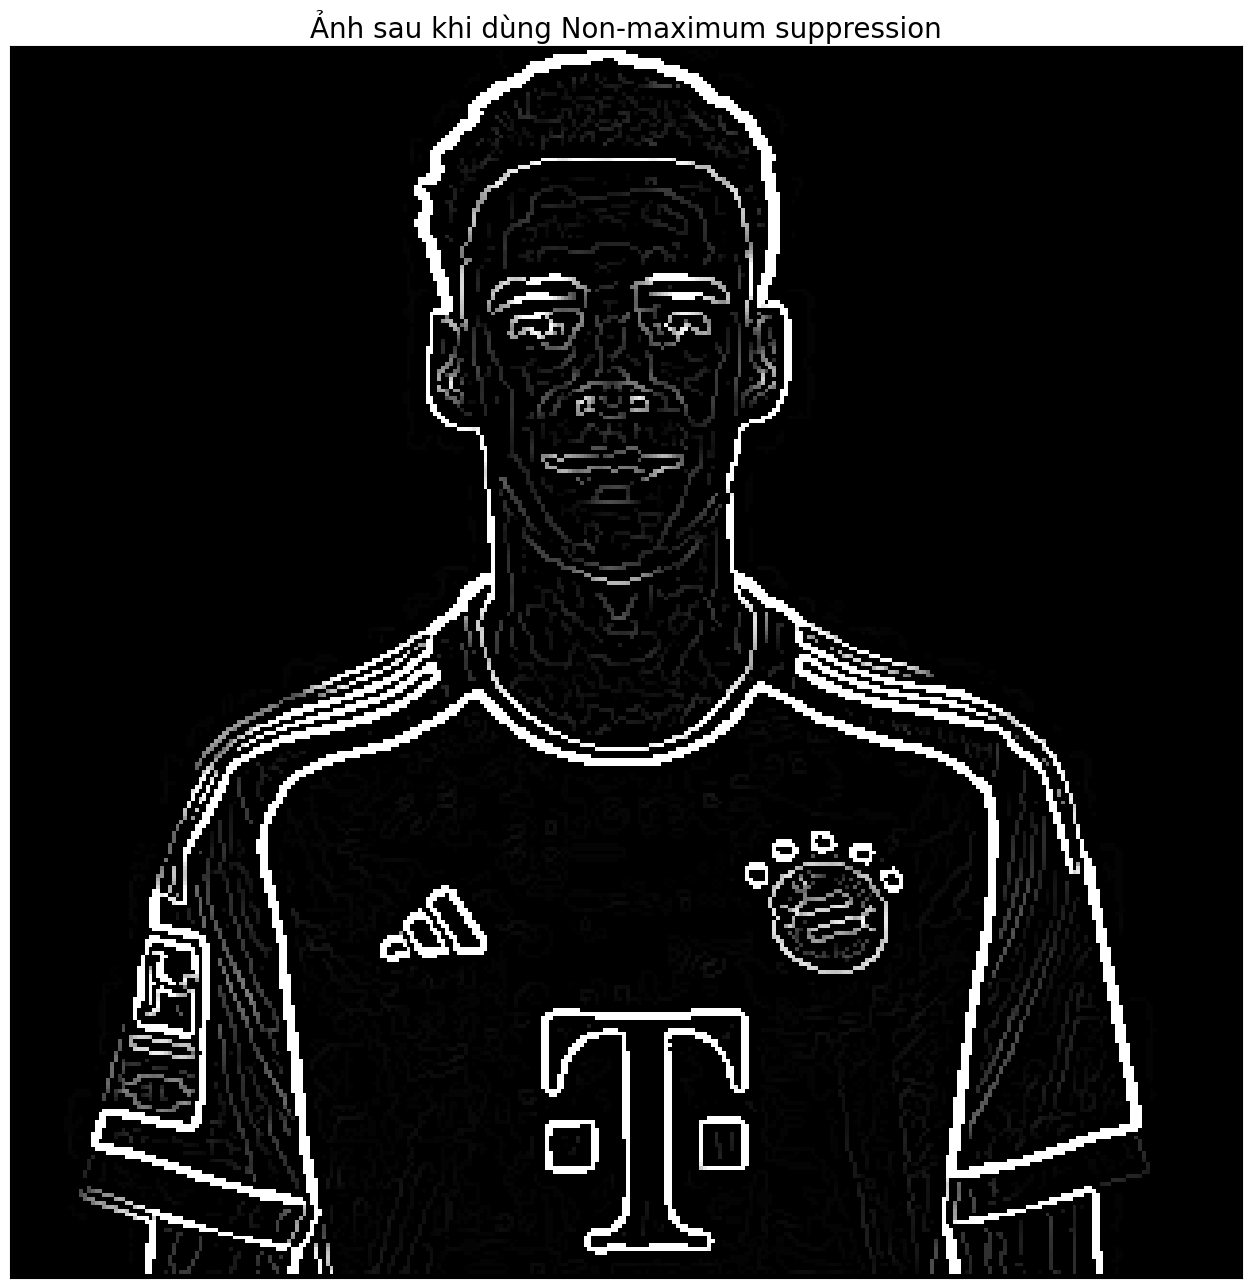

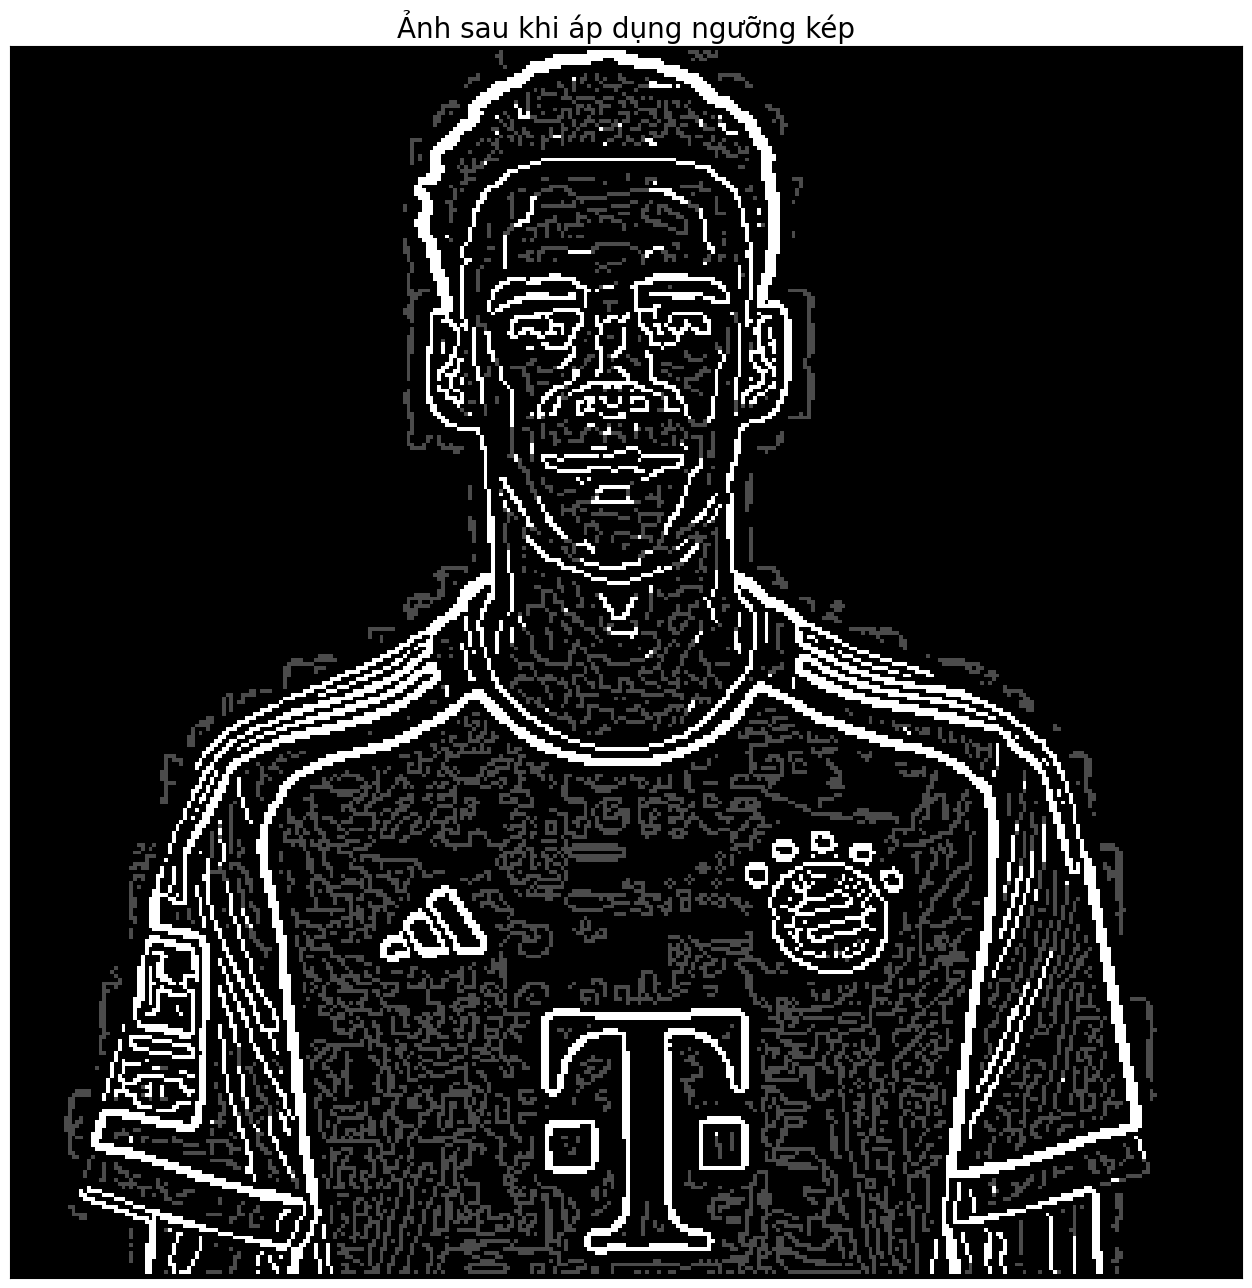

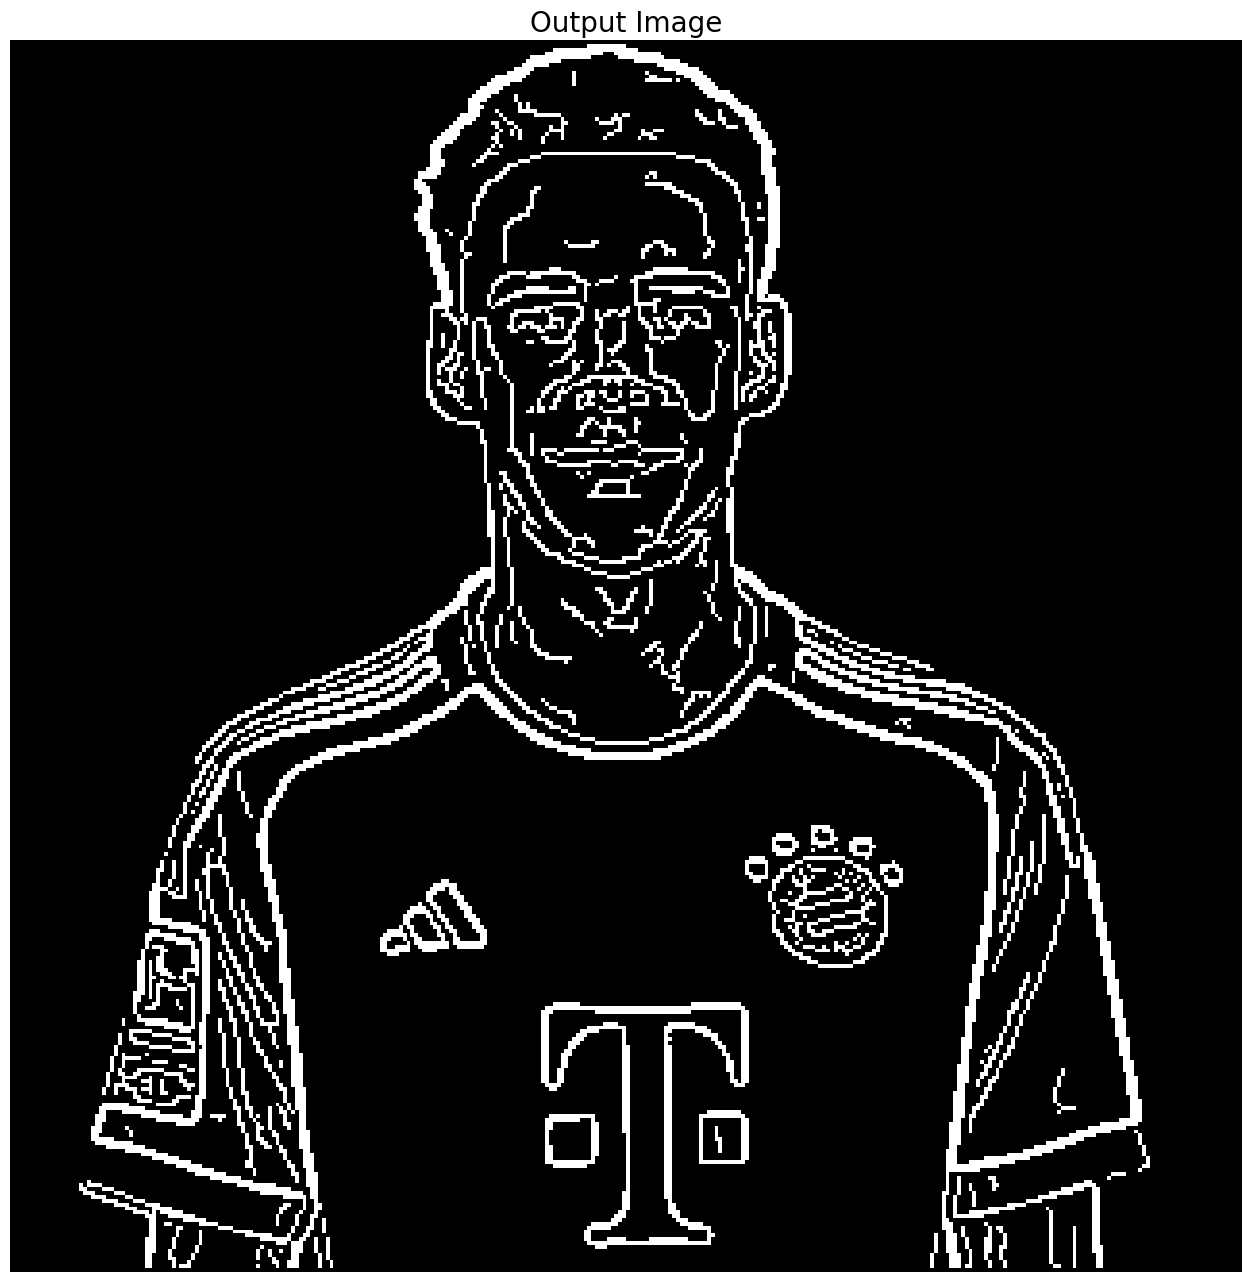

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
def gaussian_filter_5x5(size=5, sigma=1.0):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
def sobel_filter(image):
    angle = np.zeros((len(image),len(image[0])))
    sobel_filtered = np.zeros((len(image),len(image[0])))
    gx = np.zeros((len(image),len(image[0])))
    gy = np.zeros((len(image),len(image[0])))
    for i in range(1, len(image)-1): # Height
        for j in range(1, len(image[0]) - 1): # Width
            gx[i][j] = (image[i - 1][j + 1] + 2*image[i][j + 1] + image[i + 1][j + 1]) - (image[i - 1][j - 1] + 2*image[i][j - 1] + image[i + 1][j - 1]) 
            gy[i][j] = (image[i - 1][j - 1] + 2*image[i - 1][j] + image[i - 1][j + 1]) - (image[i + 1][j - 1] + 2*image[i + 1][j] + image[i + 1][j + 1])
            angle[i][j] = np.arctan2(gy[i][j], gx[i][j])
            sobel_filtered[i][j] = min(255, np.sqrt(gx[i][j]**2 + gy[i][j]**2))
    return sobel_filtered, angle
def non_max_suppression(image, angle):
    result = np.zeros((len(image),len(image[0])), dtype=np.int32)
    theta = angle * 180. / np.pi
    theta[theta < 0] += 180
    for i in range (1, len(image)-1):
        for j in range(1, len(image[0])-1):
                if (0 <= theta[i, j] < 22.5) or (157.5 <= theta[i,j] <= 180):
                    if image[i, j] == max(image[i, j+1], image[i, j], image[i, j-1]):
                        result[i, j] = image[i, j]
                elif (22.5 <= theta[i,j] < 67.5):
                    if image[i, j] == max(image[i+1, j-1], image[i, j], image[i-1, j+1]):
                        result[i, j] = image[i, j]
                elif (67.5 <= theta[i,j] < 112.5):
                    if image[i][j] == max(image[i+1, j], image[i, j], image[i-1, j]):
                        result[i, j] = image[i, j]
                elif (112.5 <= theta[i,j] < 157.5):
                    if image[i][j] == max(image[i-1, j-1], image[i, j], image[i+1, j+1]):
                        result[i, j] = image[i, j]
    return result
def threshold(image, lowThresholdRatio=0.05, highThresholdRatio=0.15):
    highThreshold = image.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    weak = np.int32(75)
    strong = np.int32(255)
    
    for i in range (0, len(image)):
        for j in range(0, len(image[0])):
            if image[i, j] >= highThreshold:
                image[i, j] = strong
            elif image[i, j] < lowThreshold:
                image[i, j] = 0
            elif lowThreshold <= image[i, j] <= highThreshold:
                image[i, j] = weak
    return image
def hysteresis_tracking(image, weak=75, strong=255):
    for i in range(1, len(image) - 1):
        for j in range(1, len(image[0]) - 1):
            if image[i, j] == weak:
                    if ((image[i - 1][j - 1] == strong) or (image[i + 1][j - 1] == strong) 
                       or (image[i - 1][j] == strong) or (image[i + 1][j] == strong)
                       or (image[i - 1][j + 1] == strong) or (image[i + 1][j + 1] == strong)
                       or (image[i][j - 1] == strong) or (image[i][j + 1] == strong)):
                        image[i, j] = strong
                    else:
                        image[i, j] = 0
    return image

img_original = Image.open("pic/Musiala.jpg")
grayscale = img_original.convert("L")
    
grayscale_image = np.array(grayscale)
plt.figure(figsize=(16, 16))
plt.imshow(grayscale_image, cmap ='gray')
plt.title('Ảnh grayscale', fontsize = 20), plt.xticks([]), plt.yticks([])
    
gaussian_filter_image = convolve(grayscale_image, gaussian_filter_5x5())
plt.figure(figsize=(16, 16))    
plt.imshow(gaussian_filter_image, cmap ='gray')
plt.title('Ảnh sau khi dùng Gaussian Filter', fontsize = 20), plt.xticks([]), plt.yticks([])
    
sobel_filter_image, angle = sobel_filter(gaussian_filter_image)
plt.figure(figsize=(16, 16))
plt.imshow(sobel_filter_image, cmap ='gray')
plt.title('Ảnh sau khi dùng Sobel Filter', fontsize = 20), plt.xticks([]), plt.yticks([]) 
    
nms_image = non_max_suppression(sobel_filter_image, angle) 
plt.figure(figsize=(16, 16))
plt.imshow(nms_image, cmap ='gray')
plt.title('Ảnh sau khi dùng Non-maximum suppression', fontsize = 20), plt.xticks([]), plt.yticks([])
    
threshold_image = threshold(nms_image)
plt.figure(figsize=(16, 16))
plt.imshow(threshold_image, cmap ='gray')
plt.title('Ảnh sau khi áp dụng ngưỡng kép', fontsize = 20), plt.xticks([]), plt.yticks([])
    
hysteresis_tracking_image = hysteresis_tracking(threshold_image)
plt.figure(figsize=(16, 16))
plt.imshow(hysteresis_tracking_image, cmap ='gray')
plt.title('Output Image', fontsize = 20), plt.xticks([]), plt.yticks([])
plt.axis('off')